In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import accuracy_score
import random 
import math

import time

AUTOTUNE = tf.data.AUTOTUNE


In [2]:
N_BEF_RES = 256
N_RES = 256 
# N_CLASSES = 143 
N_BATCH = 32 

In [10]:
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
os.listdir(PATH)

['(수정) 소아피부질환 감염성.xlsx',
 'effection',
 'models',
 'plots',
 'Total_Dataset',
 '소아피부질환 class.xlsx']

In [9]:
dataset = os.path.join(PATH, 'Total_Dataset')
dataset

'C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset'

In [ ]:
effection = ['Abscess',
             'Cellulitis',
             'Chicken pox (varicella)',
             'Cutaneous larva migrans',
             'Eczema herpeticum',
             'Folliculitis',
             'Furuncle',
             'Green nail syndrome',
             'Herpes simplex infection',
             'Herpes zoster',
             'Impetigo',
             'Molluscum contagiosum',
             'Paronychia',
             'Staphylococcal scalded skin syndrome',
             'Tinea capitis',
             'Tinea corporis',
             'Tinea cruris',
             'Tinea faciale', 
             'Tinea manus',
             'Tinea pedis',
             'Verruca plana',
             'Viral exanthem',
             'Wart']

In [4]:
# 갯수
train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    key_0 = 0 
    key_1 = 0 
    
    for f in files: 
               
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')

        # key = 0 
        # if f in effection:
        #     key = 1
            
        # if key in train_dict:
        #     train_dict[key] = train_dict[key] + len(imgs)
        # else:
        #     train_dict[key] = len(imgs)
        if f in effection:
            key_1 += len(imgs)
        else:
            key_0 += len(imgs)
            
    print(f'H{i} images => non-infection : {key_0} infection : {key_1}')
            
for i in range(7, 10): 
    # files = [val for val in list(train_dict.keys())]
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files:
        
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # key = 0 
        # if f in effection:
        #     key = 1
        
        # if key in test_dict:
        #     test_dict[key] = test_dict[key] + len(imgs) 
        # else:
        #     test_dict[key] = len(imgs) 
        # key_0 = len(imgs)
        # key_1 = len(imgs)
        if f in effection:
            key_1 += len(imgs)
        else:
            key_0 += len(imgs)
            
    print(f'H{i} images => non-infection : {key_0} infection : {key_1}')

NameError: name 'dataset' is not defined

In [5]:
train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
               
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        # print(len(imgs))
        # print(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if len(imgs) > min_num and len(imgs) <= max_num: 
        key = 0 
        if f in effection:
            key = 1
            
        if key in train_dict:
            train_dict[key] = train_dict[key] + len(imgs)
        else:
            train_dict[key] = len(imgs)
            
for i in range(7, 10): 
    # files = [val for val in list(train_dict.keys())]
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files:
        
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        key = 0 
        if f in effection:
            key = 1
        
        if key in test_dict:
            test_dict[key] = test_dict[key] + len(imgs) 
        else:
            test_dict[key] = len(imgs) 
        
train_dict, test_dict

NameError: name 'dataset' is not defined

In [6]:
lists = sorted(train_dict.items())
lists

x, y = zip(*lists) 
plt.figure(figsize=(30, 20))
plt.plot(x, y)
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [7]:
N_CLASSES = len(train_dict)

In [11]:
train_images = [] 
test_images = []

for i in range(6):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    train_images.extend(img) 
        
for i in range(7, 10):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    test_images.extend(img) 
        
        
random.shuffle(train_images)
random.shuffle(test_images)
        
len(train_images), len(test_images)

(57558, 51175)

In [27]:
def train_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        idx = f.split('\\')[2]
        
        key = 0 
        if idx in effection:
            key = 1 
            
        lbl = tf.keras.utils.to_categorical(key, len(train_dict))

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        # if base_num <= int(train_dict[idx]):
        if key == 0:
            
            # def aug(image, label):
            #     image = tf.image.random_crop(image, [RES, RES, 3])
            #     image = tf.image.random_flip_left_right(image)
            #     return image, label
            # grayscaled_img = tf.image.rgb_to_grayscale(img) 
            # yield (grayscaled_img, lbl)
            
            # saturated
            saturated_img = tf.image.adjust_saturation(img, 3)
            yield (saturated_img, lbl)
            
            
            # crop centre 
            # crop_centre_img = tf.image.central_crop(img, central_fraction=0.5)
            # yield (crop_centre_img, lbl)
            
            
            # flip 
            random_flip_img = tf.image.random_flip_left_right(img)
            yield (random_flip_img, lbl) 
            
            # Btight 
            random_bright_img = tf.image.random_brightness(img, max_delta=0.5)
            # random_bright_img = tf.clip_by_value(random_bright_img, 0, 255)
            # random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_img)
            yield (random_bright_img, lbl) 
    
            # rotation 90 
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # rotation 180
            rotated_img = tf.image.rot90(img, k=2)        
            yield (rotated_img, lbl) 
            
            # rotation 270 
            rotated_img = tf.image.rot90(img, k=3)        
            yield (rotated_img, lbl) 
            
            # curmix 
            cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            yield (cutmixed_img, cutmixed_lbl)
        

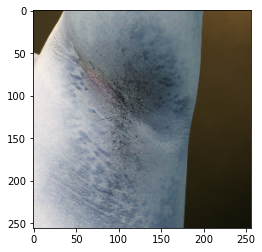

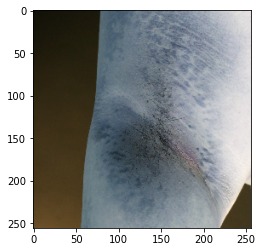

In [28]:
f = 'C:/Users/user/Desktop/Child Skin Disease/Total_Dataset/H1/Acanthosis nigricans/H1_202125_P2_L0.jpg'

img = cv2.imread(f, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

idx = f.split('/')[-2]

# cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
rotate_img = tf.image.rot90(img, k=2)

# plt.subplot(111) 
plt.imshow(img)
plt.show()
# plt.subplot(122) 
plt.imshow(rotate_img)
plt.show()

In [29]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        # lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))
        idx = f.split('\\')[2]
        
        key = 0 
        if idx in effection:
            key = 1 
            
        lbl = tf.keras.utils.to_categorical(key, len(train_dict))

        yield (img, lbl)    

In [30]:
def cutmix(images, labels):
    # imgs = []; labs = []
    # for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, len(train_images), tf.int32)
    
    # random_img = 0 
    # random_lbl = 0 
    
    random_img = cv2.imread(train_images[idx], cv2.COLOR_BGR2YCR_CB)
    random_img = cv2.resize(random_img, (N_BEF_RES, N_BEF_RES))
    random_img = cv2.normalize(random_img, None, 0, 255, cv2.NORM_MINMAX)
    
    random_idx = train_images[idx].split('\\')[2]
    
    random_key = 0 
    if random_idx in effection:
        random_key = 1
        
    random_lbl = tf.keras.utils.to_categorical(random_key, N_CLASSES)

    W = N_RES
    H = N_RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[ymin:ymax, :xmin, :]
    # mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_mid = random_img[ymin:ymax, xmin:xmax, :]
    mid_right = images[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[:ymin, :, :]
    bottom = images[ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    # imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    # label1 = labels[i]
    label1 = labels
    # label2 = labels[idx]
    label2 = random_lbl
    new_label = ((1-alpha)*label1 + alpha*label2)
    # labs.append(new_label)
        
    # new_imgs = tf.reshape(tf.stack(imgs), [-1, N_RES, N_RES, 3])
    # new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASSES])

    return new_img, new_label


In [31]:
def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [32]:
def create_class_weight(labels_dict, n_classes=10):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for idx, key in zip(range(N_CLASSES), keys):
        score = total / (n_classes * train_dict[key])
        class_weight[idx] = score
        
    return class_weight
        
class_weights = create_class_weight(train_dict, N_CLASSES)
class_weights

{0: 4.409223226597212, 1: 0.5639513237051988}

In [33]:
def run_expriment(model_name, train_dataset, val_dataset, optimizer='adam', trainable=False, batch_size=32, mc=False, epochs=100): 
    
    if model_name == 'efficient':
        base_model = keras.applications.EfficientNetB4(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = trainable
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = get_dropout(x, mc)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        

    sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'{PATH}/models/{model_name}_mc-{mc}_bs-{batch_size}_{time.strftime("%Y%m%d-%H%M%S")}.h5'), 
                                             monitor='val_accuracy', 
                                             verbose=0, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='max', 
                                             save_freq='epoch'), 
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                           patience = 4, 
                                           mode='auto',
                                           min_delta = 0.01)
          ]

    
    LR = 0.0001
    steps_per_epoch = len(train_images) // batch_size
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)
    
    # sgd = tf.keras.optimizers.SGD(0.01)
    # moving_avg_sgd = tfa.optimizers.MovingAverage(sgd)
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr_schedule)
    else:
        optimizer = tf.keras.optimizers.SGD(lr_schedule)
    
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                  optimizer = optimizer,
                  metrics=['accuracy',
                        #    tf.keras.metrics.Precision(name='precision'),
                        #    tf.keras.metrics.Recall(name='precision'),
                        #    tf.keras.metrics.Precision(name='precision'),
                           ])
    
    hist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs,
                    # class_weight=class_weights, 
                    verbose = 1,
                    # shuffle = True,
                    # callbacks = [sv]
                    )
    
    # histories.append(hist)
    
    return model, hist
    

In [10]:
train_dataset = tf.data.Dataset.from_generator(train_skin_data, 
                                               output_types=(tf.float64, tf.float32), 
                                               output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([N_CLASSES])),
                                               args=[train_images])

test_dataset = tf.data.Dataset.from_generator(test_skin_data, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([N_CLASSES])),
                                              args=[test_images])


NameError: name 'train_skin_data' is not defined

In [35]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
split_val_dataset = train_dataset.take(split_size)

split_train_dataset = split_train_dataset.shuffle(128).batch(32).prefetch(AUTOTUNE)
split_val_dataset = split_val_dataset.shuffle(128).batch(32).prefetch(AUTOTUNE)

In [37]:
# with tf.device('/device:GPU:0'):
model, hist = run_expriment('efficient', split_train_dataset, split_val_dataset, optimizer='adam', batch_size=32, trainable=True, epochs=25)

Epoch 1/25
12602/12602 [==============================] - 7159s 563ms/step - loss: 0.0186 - accuracy: 0.9830 - val_loss: 0.0201 - val_accuracy: 0.9772
Epoch 2/25
12602/12602 [==============================] - 7351s 579ms/step - loss: 0.0123 - accuracy: 0.9869 - val_loss: 0.0254 - val_accuracy: 0.9787
Epoch 3/25
12602/12602 [==============================] - 7289s 574ms/step - loss: 0.0076 - accuracy: 0.9909 - val_loss: 0.0176 - val_accuracy: 0.9823
Epoch 4/25
12602/12602 [==============================] - 7212s 568ms/step - loss: 0.0053 - accuracy: 0.9933 - val_loss: 0.0197 - val_accuracy: 0.9800
Epoch 5/25
12602/12602 [==============================] - 7010s 552ms/step - loss: 0.0036 - accuracy: 0.9954 - val_loss: 0.0186 - val_accuracy: 0.9837
Epoch 6/25
12602/12602 [==============================] - 6921s 545ms/step - loss: 0.0019 - accuracy: 0.9976 - val_loss: 0.0207 - val_accuracy: 0.9837
Epoch 7/25
12602/12602 [==============================] - 6910s 544ms/step - loss: 0.0015 - ac

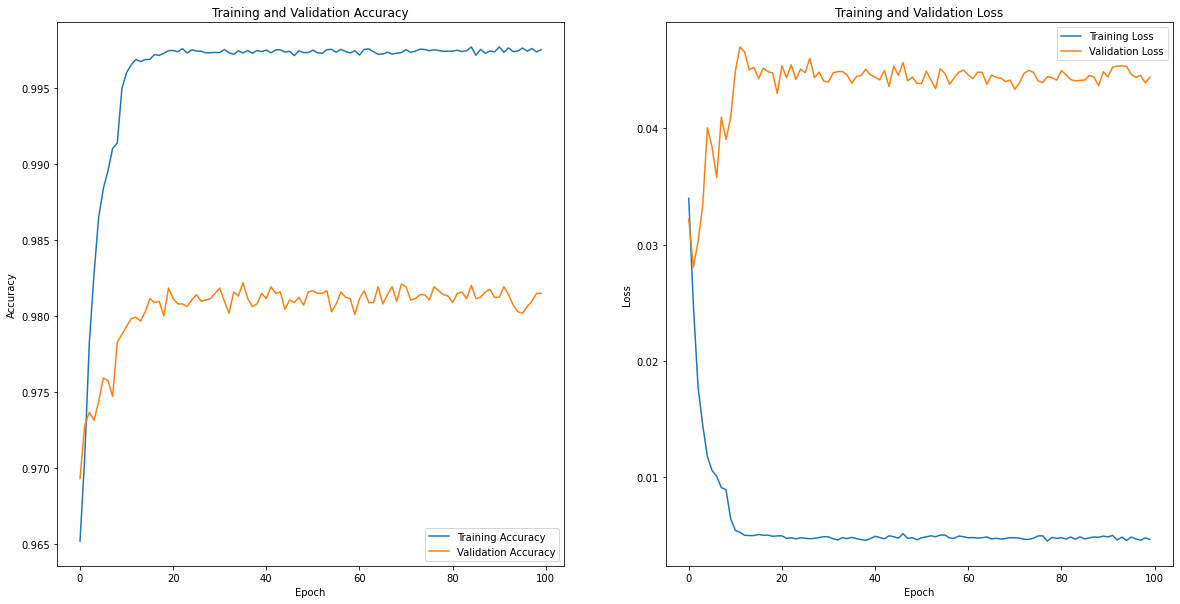

In [117]:
# hist
# for hist in histories:
plt.figure(1, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show() 

In [43]:
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)

model.evaluate(test_dataset)

1600/1600 [==============================] - 293s 183ms/step - loss: 0.5400 - accuracy: 0.8932


[0.5400100946426392, 0.8931509256362915]

In [55]:
# y_pred - 
# def test_skin_data(files):
files = []
for i in range(7, 10):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    files.extend(img) 

files

['C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P2_L0.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P2_L1.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P3_L0.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P3_L3.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P3_L4.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P3_L5.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5349_P3_L6.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5350_P1_L0.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5350_P1_L1.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5350_P1_L2.jpg',
 'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset/H7\\Abscess\\H7_5350_P1_L3.jpg',

In [80]:
test_images = [] 
test_labels = []

random.shuffle(files)
    
for f in files:

    # f = file.decode('utf-8')
    
    img = cv2.imread(f, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))
    idx = f.split('\\')[2]
    
    key = 0 
    if idx in effection:
        key = 1 
        
    lbl = tf.keras.utils.to_categorical(key, len(train_dict))
    
    test_images.append(img)
    test_labels.append(lbl) 


In [81]:
# len(test_images)
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_CLASSES])

In [82]:
test_images.shape, test_labels.shape

((51175, 256, 256, 3), (51175, 2))

In [83]:
y_pred = model.predict(test_images[:1000])

In [100]:
import sklearn 

# sklearn.metrics.f1_score(test_labels[:100], y_pred, average='binary')
cm = sklearn.metrics.confusion_matrix(test_labels[:1000].argmax(axis=1), y_pred.argmax(axis=1))
cm 

array([[858,  12],
       [ 97,  33]], dtype=int64)

In [108]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [106]:
f1_score = sklearn.metrics.f1_score(test_labels[:1000].argmax(axis=1), y_pred.argmax(axis=1))
precision = sklearn.metrics.precision_score(test_labels[:1000].argmax(axis=1), y_pred.argmax(axis=1))
recall = sklearn.metrics.recall_score(test_labels[:1000].argmax(axis=1), y_pred.argmax(axis=1))

f1_score, precision, recall

(0.37714285714285717, 0.7333333333333333, 0.25384615384615383)

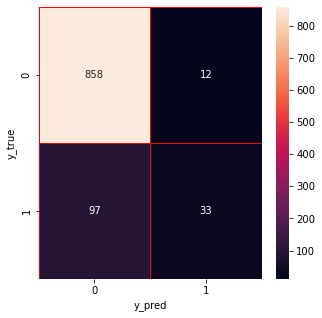

In [103]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [122]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('FPR')    
    plt.ylabel('TPR')

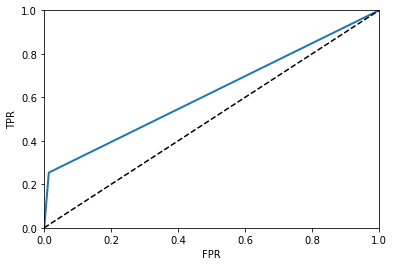

In [123]:
#roc curve 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels[:1000].argmax(axis=1), y_pred.argmax(axis=1))
# fpr, tpr, thresholds
plot_roc_curve(fpr, tpr)

In [124]:
from sklearn.metrics import auc 

auc(fpr, tpr)

0.620026525198939

## model save

In [49]:
# model.save(PATH + '/effection/' + '20220614_efficientb4_100.h5')
model.save('20220614_efficientb4_100.h5')

In [52]:
import pandas as pd
hist_df = pd.DataFrame(hist.history)
with open('20220614_efficientb4_100_history.csv', mode='w') as f:
    hist_df.to_csv(f)